# Car Price Modeling
## Objective
The objective is to use data on car sales to build a model that can predict selling price.

**Source:** The dataset was downloaded from Kaggle.

## 1. Load the Data

In [708]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [709]:
cars = pd.read_csv("car_details.csv")

In [710]:
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [711]:
cars.shape

(8128, 13)

In [712]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


## 2. Data Cleaning
#### Rounding Year
The year column will be rounded for easier visualization.

In [713]:
cars["year"] = round(cars["year"], 0)

#### Scaling
Selling_price and km_driven have a high magnitude. To better visualize the data, the values in selling_price will be converted to thousands of USD (from rupees), and km_driven will be converted to thousands km_driven.

In [714]:
# 1 rupee = 0.014 USD

cars["selling_price"] = cars["selling_price"] * .014
cars["km_driven_th"] = cars["km_driven"]/1000

#### Removing Units
Mileage, engine, and max_power include units in each data point. The units will be removed and incorporated into the column name.

All but 88 records are in kmpl units. These records will be removed.

In [715]:
cars["mileage_kmpl"] = cars["mileage"].str.replace("\skmpl", "")
cars = cars.drop("mileage", axis=1)

In [716]:
cars["engine_cc"] = cars["engine"].str.replace("\sCC", "")
cars = cars.drop("engine", axis=1)

In [717]:
cars["max_power_bph"] = cars["max_power"].str.replace("\sbhp", "")
cars = cars.drop("max_power", axis=1)

In [718]:
cars = cars[~cars["mileage_kmpl"].str.contains("km/kg", na=False)]

In [719]:
# Convert to float
cars[["mileage_kmpl", "engine_cc", "max_power_bph"]] = cars[["mileage_kmpl", "engine_cc", "max_power_bph"]].astype(float)

#### Hidden Missing Values
Mileage and max_power contain data points with a value of 0. These should be marked as missing values.

In [720]:
cars[cars.mileage_kmpl.eq(0)] = np.nan
cars[cars.max_power_bph.eq(0)] = np.nan

#### Remove Torque
The torque column has high cardinality with differing units and will not be used for predictions. This column will be removed.

In [721]:
cars = cars.drop("torque", axis=1)

In [722]:
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,km_driven_th,mileage_kmpl,engine_cc,max_power_bph
0,Maruti Swift Dzire VDI,2014.0,6300.0,145500.0,Diesel,Individual,Manual,First Owner,5.0,145.5,23.40,1248.0,74.00
1,Skoda Rapid 1.5 TDI Ambition,2014.0,5180.0,120000.0,Diesel,Individual,Manual,Second Owner,5.0,120.0,21.14,1498.0,103.52
2,Honda City 2017-2020 EXi,2006.0,2212.0,140000.0,Petrol,Individual,Manual,Third Owner,5.0,140.0,17.70,1497.0,78.00
3,Hyundai i20 Sportz Diesel,2010.0,3150.0,127000.0,Diesel,Individual,Manual,First Owner,5.0,127.0,23.00,1396.0,90.00
4,Maruti Swift VXI BSIII,2007.0,1820.0,120000.0,Petrol,Individual,Manual,First Owner,5.0,120.0,16.10,1298.0,88.20


#### Outliers
The selling price and km_driven columns contain outliers far removed from the rest of the dataset. These outliers will be removed.

In [723]:
# selling_price

first_quartile = cars["selling_price"].describe()['25%']
third_quartile = cars["selling_price"].describe()['75%']
iqr = third_quartile - first_quartile

# Remove outliers
cars = cars[(cars["selling_price"] > (first_quartile - 3 * iqr)) &
            (cars["selling_price"] < (third_quartile + 3 * iqr))]

In [724]:
# km_driven

first_quartile = cars["km_driven"].describe()['25%']
third_quartile = cars["km_driven"].describe()['75%']
iqr = third_quartile - first_quartile

# Remove outliers
cars = cars[(cars["km_driven"] > (first_quartile - 3 * iqr)) &
            (cars["km_driven"] < (third_quartile + 3 * iqr))]

## 3. Exploratory Data Analysis
#### Statistics

In [725]:
cars.describe()

,year,selling_price,km_driven,seats,km_driven_th,mileage_kmpl,engine_cc,max_power_bph
count,7583.000000,7583.000000,7583.000000,7370.000000,7583.000000,7370.000000,7370.000000,7370.000000
mean,2013.622841,6771.682135,70540.874852,5.430393,70.540875,19.581357,1418.115875,86.699766
std,4.041517,4382.196969,44797.836109,0.970510,44.797836,3.880168,472.835100,27.897259
min,1983.000000,419.986000,1000.000000,4.000000,1.000000,9.000000,624.000000,34.200000
25%,2011.000000,3500.000000,35000.000000,5.000000,35.000000,17.000000,1197.000000,68.000000
50%,2014.000000,6020.000000,65000.000000,5.000000,65.000000,19.670000,1248.000000,81.860000
75%,2017.000000,9058.000000,100000.000000,5.000000,100.000000,22.540000,1498.000000,98.960000
max,2020.000000,27132.000000,291977.000000,14.000000,291.977000,28.400000,3498.000000,272.000000


#### Single Variable

Text(0.5, 1.0, 'Selling Price Distribution')

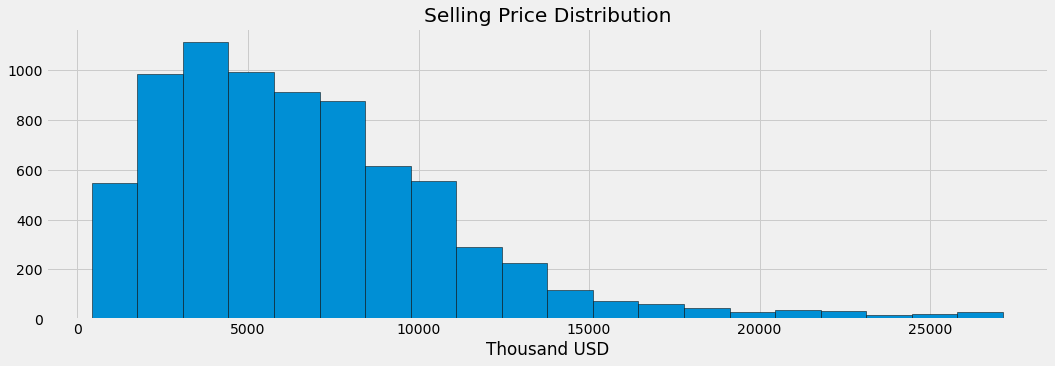

In [726]:
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=(16,5))
plt.hist(cars.selling_price, ec="black", bins=20)
plt.xlabel("Thousand USD")
plt.title("Selling Price Distribution")

Text(0.5, 1.0, 'Kilometers Driven Distribution')

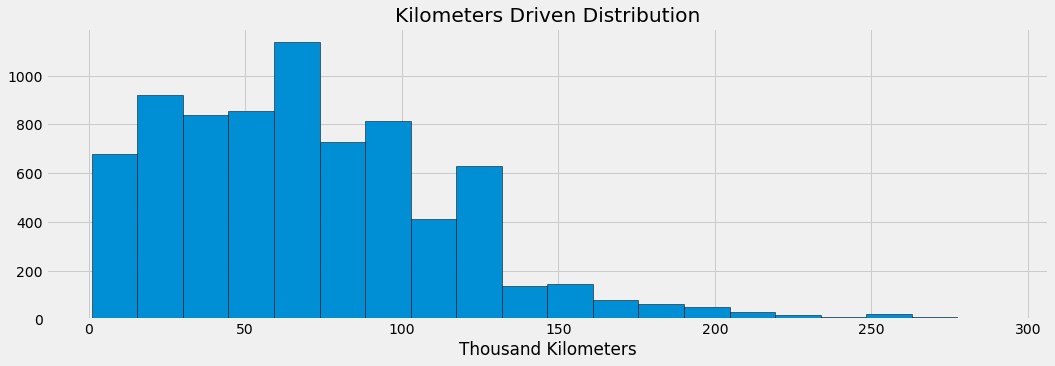

In [727]:
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=(16,5))
plt.hist(cars.km_driven_th, ec="black", bins=20)
plt.xlabel("Thousand Kilometers")
plt.title("Kilometers Driven Distribution")

<AxesSubplot:xlabel='count', ylabel='seats'>

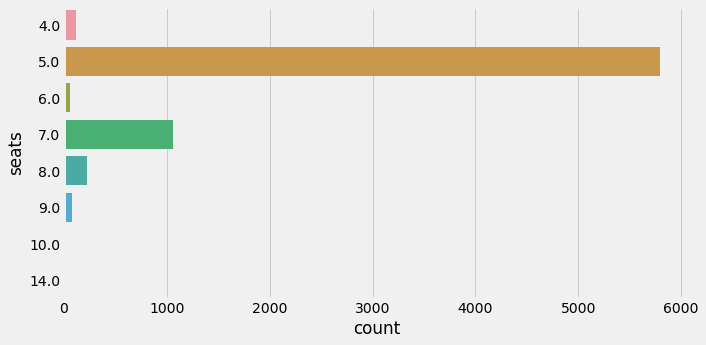

In [728]:
fig = plt.figure(figsize=(10,5))
sns.countplot(y="seats", data=cars)

Text(0.5, 1.0, 'Transmission Distribution')

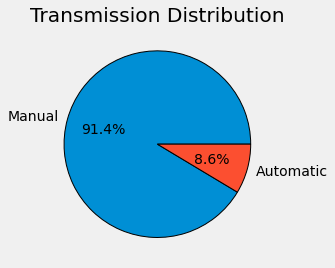

In [729]:
plt.pie(x=cars.transmission.value_counts(), labels=["Manual", "Automatic"], autopct="%1.1f%%", 
        wedgeprops={"edgecolor":"0","linewidth": 1})
plt.title("Transmission Distribution")

Text(0.5, 1.0, 'Seller Type Distribution')

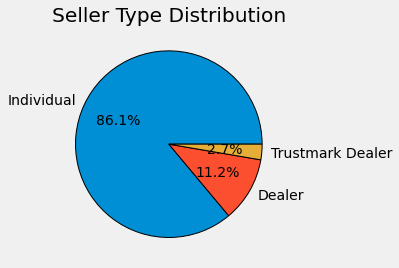

In [730]:
plt.pie(x=cars.seller_type.value_counts(), labels=["Individual", "Dealer", "Trustmark Dealer"], autopct="%1.1f%%", 
        wedgeprops={"edgecolor":"0","linewidth": 1})
plt.title("Seller Type Distribution")

#### Relationships

C:\Users\Samantha\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Selling Price by Number of Owners')

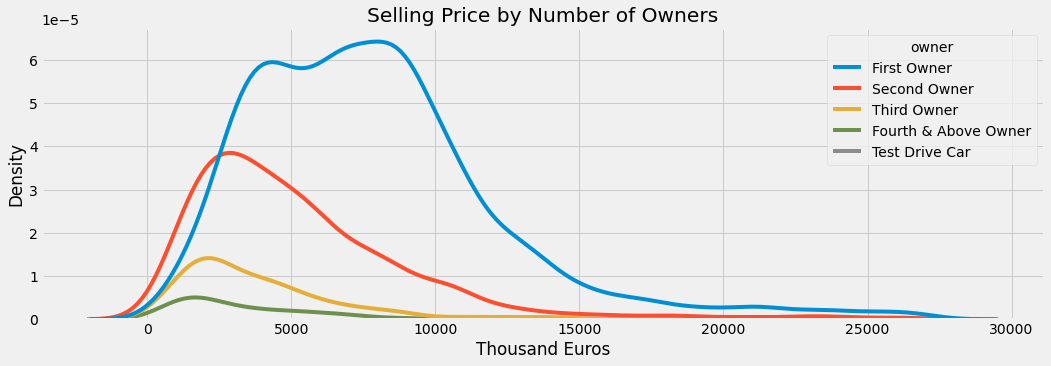

In [731]:
fig = plt.figure(figsize=(16,5))
sns.kdeplot(x="selling_price", hue="owner", data=cars)
plt.xlabel("Thousand Euros")
plt.title("Selling Price by Number of Owners")

Text(0.5, 1.0, 'Selling Price by Fuel Type')

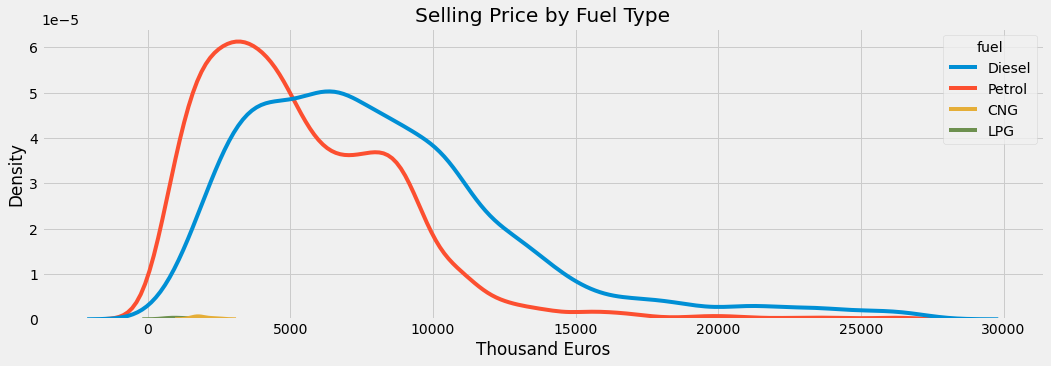

In [732]:
fig = plt.figure(figsize=(16,5))
sns.kdeplot(x="selling_price", hue="fuel", data=cars)
plt.xlabel("Thousand Euros")
plt.title("Selling Price by Fuel Type")

Text(0.5, 1.0, 'Selling Price by Fuel Type')

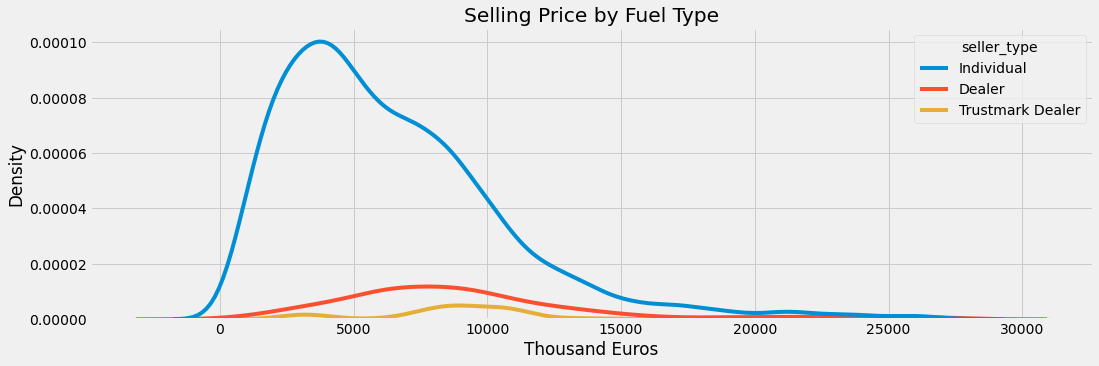

In [733]:
fig = plt.figure(figsize=(16,5))
sns.kdeplot(x="selling_price", hue="seller_type", data=cars)
plt.xlabel("Thousand Euros")
plt.title("Selling Price by Fuel Type")

#### Correlation

In [734]:
cars = cars.drop("km_driven_th", axis=1)

In [735]:
cars.corr()["selling_price"].sort_values()

km_driven       -0.232675
mileage_kmpl    -0.072326
seats            0.270257
engine_cc        0.455465
year             0.583374
max_power_bph    0.648804
selling_price    1.000000
Name: selling_price, dtype: float64

## 4. Preprocessing

#### Split X and y, features and target

In [736]:
X = cars.drop(["selling_price", "name"], axis=1)
y = cars.selling_price

#### One-Hot Encoding
Get dummies for categorical variables transmission, fuel, seller_type, and owner.

In [737]:
X = pd.get_dummies(X, columns=["transmission", "fuel", "seller_type", "owner"], drop_first=True) 
# dropfirst = True to avoid collinearity

In [738]:
X.head()

,year,km_driven,seats,mileage_kmpl,engine_cc,max_power_bph,transmission_Manual,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014.0,145500.0,5.0,23.40,1248.0,74.00,1,1,0,0,1,0,0,0,0,0
1,2014.0,120000.0,5.0,21.14,1498.0,103.52,1,1,0,0,1,0,0,1,0,0
2,2006.0,140000.0,5.0,17.70,1497.0,78.00,1,0,0,1,1,0,0,0,0,1
3,2010.0,127000.0,5.0,23.00,1396.0,90.00,1,1,0,0,1,0,0,0,0,0
4,2007.0,120000.0,5.0,16.10,1298.0,88.20,1,0,0,1,1,0,0,0,0,0


#### Split train and test set

In [739]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Missing Values
Seats, mileage, engine, and max_power each have 213 missing values. These values will be imputed using the median.

In [740]:
X.isnull().sum()

year                              0
km_driven                         0
seats                           213
mileage_kmpl                    213
engine_cc                       213
max_power_bph                   213
transmission_Manual               0
fuel_Diesel                       0
fuel_LPG                          0
fuel_Petrol                       0
seller_type_Individual            0
seller_type_Trustmark Dealer      0
owner_Fourth & Above Owner        0
owner_Second Owner                0
owner_Test Drive Car              0
owner_Third Owner                 0
dtype: int64

In [741]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')

X_train = X_train.copy()
X_test = X_test.copy()

imp_cols = ["seats", "mileage_kmpl", "engine_cc", "max_power_bph"]

for col in imp_cols:
    X_train.loc[:, col] = imputer.fit_transform(np.array(X_train[col]).reshape(-1, 1))
    X_test.loc[:, col] = imputer.transform(np.array(X_test[col]).reshape(-1, 1))

#### Scaling
Normalize year, seats, km_driven, mileage_kmpl, engine_cc, max_power_bph.

In [742]:
scaler = MinMaxScaler(feature_range=(0, 1))

scale_cols = ["year", "km_driven", "seats", "mileage_kmpl", "engine_cc", "max_power_bph"]

for col in scale_cols:
    X_train.loc[:, col] = scaler.fit_transform(np.array(X_train[col]).reshape(-1, 1))
    X_test.loc[:, col] = scaler.transform(np.array(X_test[col]).reshape(-1, 1))

In [743]:
X_test.head()

,year,km_driven,seats,mileage_kmpl,engine_cc,max_power_bph,transmission_Manual,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
831,0.648649,0.340233,0.1,0.453608,0.160752,0.121110,1,0,0,1,1,0,0,1,0,0
699,0.729730,0.649536,0.1,0.453608,0.217119,0.171573,1,1,0,0,1,0,0,1,0,0
940,0.702703,0.408967,0.1,0.469072,0.302366,0.318755,1,1,0,0,1,0,0,0,0,0
4688,0.945946,0.134031,0.1,0.574227,0.304106,0.226241,1,1,0,0,0,0,0,0,0,0
7526,0.729730,0.556745,0.1,0.453608,0.269659,0.142136,1,1,0,0,1,0,0,0,0,0


## 5. Predictive Modeling
#### Baseline

In [744]:
# Function to calculate mean absolute error
def mae(y, y_pred):
    return np.mean(abs(y - y_pred))

In [745]:
baseline = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline)
print("Baseline performance on the test set: Mean Absolute Error = %0.4f" % mae(y_test, baseline))

The baseline guess is a score of 6020.00
Baseline performance on the test set: Mean Absolute Error = 3168.6703


#### Run Models

In [762]:
# Create function to fit and evaluate models
def fit_evaluate(model):
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    pred = model.predict(X_test)
    error = mae(y_test, pred)
    
    print('MAE = %0.4f' % error)
    
    # Return the performance metric
    return error

In [763]:
# Linear Regression
lr = LinearRegression()
lr_mae = fit_evaluate(lr)

MAE = 1662.3067


In [764]:
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf_mae = fit_evaluate(rf)

MAE = 807.1199


In [765]:
# Support Vector Machine
svm = SVR()
svm_mae = fit_evaluate(svm)

MAE = 3048.3857


In [766]:
# K-Nearest Neighbors
knn = KNeighborsRegressor()
knn_mae = fit_evaluate(knn)

MAE = 1140.3715


In [768]:
# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb_mae = fit_evaluate(gb)

MAE = 1034.6395


In [770]:
results = pd.DataFrame({'model': ['Linear Regression', 'Random Forest', 
                                           'Support Vector Machine',
                                            'K-Nearest Neighbors',
                                           'Gradient Boosted'],
                                 'mae': [lr_mae, rf_mae, svm_mae, 
                                         knn_mae, gb_mae]})

Text(0.5, 0, 'Mean Absolute Error')

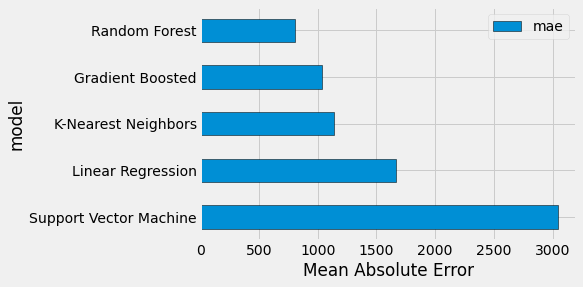

In [772]:
results.sort_values('mae', ascending = False).plot(x='model', y='mae', kind ='barh', edgecolor = 'black')
plt.xlabel("Mean Absolute Error")